<a href="https://colab.research.google.com/github/imabari/ImabariScraping/blob/master/kumamoto/kumamoto_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インストール

In [1]:
!pip install pycurl
!pip install retry

     |████████████████████████████████| 225kB 3.4MB/s 
  Created wheel for pycurl: filename=pycurl-7.43.0.5-cp36-cp36m-linux_x86_64.whl size=283510 sha256=704772e48439ff0f82e58eb14a5862d40241271df230d9f82d66a9e263edaeb8
  Stored in directory: /root/.cache/pip/wheels/98/a3/19/9439c79b88a742f508af0c4e410ae3f685db2e13d3374e798e
Successfully built pycurl


In [2]:
!pip install -U pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)


# オープンデータ

In [0]:
SOUDAN_CSV = "https://www.pref.kumamoto.jp/common/UploadFileOutput.ashx?c_id=3&id=22038&sub_id=7&flid=231832"
KANJA_CSV = "https://www.pref.kumamoto.jp/common/UploadFileOutput.ashx?c_id=3&id=22038&sub_id=7&flid=231833"
KENSA_CSV = "https://www.pref.kumamoto.jp/common/UploadFileOutput.ashx?c_id=3&id=22038&sub_id=7&flid=231834"

# 設定

In [0]:
USER_AGENT = "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko"

DOWNLOAD_DIR = "download"
DATA_DIR = "data"

# データラングリング

In [0]:
import pycurl
from retry import retry
import pathlib

In [0]:
@retry(tries=5, delay=5, backoff=3)
def get_file(url, file_name, dir="."):

    p = pathlib.Path(dir, file_name)

    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as f:

        c = pycurl.Curl()
        c.setopt(c.URL, url)
        c.setopt(pycurl.USERAGENT, USER_AGENT)
        c.setopt(c.WRITEDATA, f)
        c.perform()
        c.close()

    return p

In [0]:
import pandas as pd

In [0]:
import datetime
import pathlib
import json

In [0]:
JST = datetime.timezone(datetime.timedelta(hours=+9), "JST")

In [0]:
dt_now = datetime.datetime.now(JST)
dt_update = dt_now.strftime("%Y/%m/%d %H:%M")

In [0]:
data = {"lastUpdate": dt_update}

# 相談件数

In [0]:
soudan_path = get_file(SOUDAN_CSV, "soudan.csv", DOWNLOAD_DIR)
df_soudan = pd.read_csv(soudan_path).iloc[:-1]

In [0]:
df_soudan["受付_年月日"] = pd.to_datetime(df_soudan["受付_年月日"])

In [0]:
df_soudan.set_index("受付_年月日", inplace=True)

In [0]:
df_contacts = pd.to_numeric(df_soudan["相談件数"], errors='coerce').dropna().astype(int).reset_index()

df_contacts["日付"] = df_contacts["受付_年月日"].dt.strftime("%Y-%m-%d")

df_contacts.rename(columns={"相談件数": "小計"}, inplace=True)

df_contacts.drop(columns=["受付_年月日"], inplace=True)

data["contacts"] = {
    "data": df_contacts.to_dict(orient="records"),
    "date": dt_update,
}

In [16]:
df_contacts

,小計,日付
0,55,2020-02-04
1,34,2020-02-05
2,26,2020-02-06
3,25,2020-02-07
4,20,2020-02-08
...,...,...
67,343,2020-04-11
68,395,2020-04-12
69,937,2020-04-13
70,563,2020-04-14


# 検査

In [0]:
kensa_path = get_file(KENSA_CSV, "kensa.csv", DOWNLOAD_DIR)
df_kensa = pd.read_csv(kensa_path).pivot(index="実施_年月日", columns="全国地方公共団体コード", values="検査実施_件数").dropna().astype(int)

In [0]:
df_kensa.rename(columns={430005: "熊本県", 431001: "熊本市"}, inplace=True)

In [0]:
df_kensa.index = pd.to_datetime(df_kensa.index)

In [0]:
df_kensa.sort_index(inplace=True)

In [0]:
df_kensa.to_csv("kumamoto_kensa.csv", encoding="utf_8_sig")

In [0]:
labels = df_kensa.index.map(lambda s: f"{s.month}/{s.day}")

In [0]:
data["inspections_summary"] = {
    "data": df_kensa.to_dict(orient="list"),
    "labels": labels.tolist(),
    "date": dt_update,
}

# 患者

In [0]:
kanja_path = get_file(KANJA_CSV, "kanja.csv", DOWNLOAD_DIR)
df_kanja = pd.read_csv(kanja_path, index_col="No", parse_dates=["公表_年月日", "確定_年月日"])

In [0]:
df_kanja.columns = df_kanja.columns.map(lambda s: s.replace("患者_", ""))

In [0]:
df_kanja["リリース日"] = df_kanja["公表_年月日"].dt.strftime("%Y-%m-%dT08:00:00.000Z")
df_kanja["date"] = df_kanja["公表_年月日"].dt.strftime("%Y-%m-%d")

In [0]:
weeks = ["月", "火", "水", "木", "金", "土", "日"]
df_kanja["曜日"] = df_kanja["公表_年月日"].dt.dayofweek.apply(lambda x: weeks[x])

In [0]:
df_kanja["退院"] = df_kanja["退院済フラグ"].replace({1: "○", 0: None})

In [0]:
patients = df_kanja.loc[:, [ "リリース日", "曜日", "居住地", "年代", "性別", "退院", "date"]]

In [0]:
data["patients"] = {
    "data": patients.to_dict(orient="records"),
    "date": dt_update,
}

In [0]:
df_patients_sum = (
    df_kanja["公表_年月日"].value_counts().sort_index().asfreq("D", fill_value=0).reset_index()
)

df_patients_sum["日付"] = df_patients_sum["index"].dt.strftime("%Y-%m-%dT08:00:00.000Z")

df_patients_sum.rename(columns={"公表_年月日": "小計"}, inplace=True)

df_patients_sum.drop(columns=["index"], inplace=True)

data["patients_summary"] = {
    "data": df_patients_sum.to_dict(orient="records"),
    "date": dt_update,
}

In [32]:
df_kanja

,全国地方公共団体コード,都道府県名,市区町村名,公表_年月日,確定_年月日,居住地,年代,性別,職業,状態,症状,渡航歴の有無フラグ,退院済フラグ,備考,リリース日,date,曜日,退院
No,,,,,,,,,,,,,,,,,,
1,430005,熊本県,熊本市,2020-02-22,2020-02-21,熊本市東区,20代,女性,看護師,NaN,NaN,0,1,NaN,2020-02-22T08:00:00.000Z,2020-02-22,土,○
2,430005,熊本県,熊本市,2020-02-22,2020-02-21,熊本市東区,50代,男性,土木作業員,無症状,NaN,0,0,NaN,2020-02-22T08:00:00.000Z,2020-02-22,土,None
3,430005,熊本県,NaN,2020-02-22,2020-02-22,御船保健所管内,60代,男性,無職,重症,息苦しさ,0,0,NaN,2020-02-22T08:00:00.000Z,2020-02-22,土,None
4,430005,熊本県,熊本市,2020-02-25,2020-02-24,熊本市東区,50代,男性,土木作業員,NaN,NaN,0,1,NaN,2020-02-25T08:00:00.000Z,2020-02-25,火,○
5,430005,熊本県,熊本市,2020-02-25,2020-02-25,熊本市東区,60代,女性,会社員,NaN,NaN,0,1,NaN,2020-02-25T08:00:00.000Z,2020-02-25,火,○
6,430005,熊本県,NaN,2020-03-04,2020-03-04,有明保健所管内,40代,女性,介護職,NaN,NaN,0,1,NaN,2020-03-04T08:00:00.000Z,2020-03-04,水,○
7,430005,熊本県,熊本市,2020-03-19,2020-03-19,熊本市東区,20代,女性,無職,無症状,NaN,1,0,NaN,2020-03-19T08:00:00.000Z,2020-03-19,木,None
8,430005,熊本県,熊本市,2020-03-25,2020-03-25,不定,70代,男性,無職,死亡,NaN,0,1,NaN,2020-03-25T08:00:00.000Z,2020-03-25,水,○
9,430005,熊本県,熊本市,2020-03-27,2020-03-27,熊本市中央区,60代,男性,自営業,無症状,NaN,0,0,NaN,2020-03-27T08:00:00.000Z,2020-03-27,金,None


In [0]:
# 状態の内死亡以外（無症状・軽症・中等症・重症・非公表）を症状にコピー
df_kanja["症状"] = df_kanja["状態"].mask(df_kanja["状態"] == "死亡")

# 状態の内死亡以外を入院中に変更
df_kanja["状況"] = df_kanja["状態"].where(df_kanja["状態"] == "死亡", "入院中")

# 状態が死亡以外でかつ退院済みフラグが1の場合を退院に変更
df_kanja["状況"] = df_kanja["状況"].mask((df_kanja["退院済フラグ"] == 1) & (df_kanja["状態"] != "死亡"), "退院")

situation = df_kanja["状況"].value_counts()
condition = df_kanja["症状"].value_counts()

In [0]:
data["main_summary"] = {
    "attr": "検査実施人数",
    "value": int(df_kensa.sum(axis=1).sum()),
    "children": [
        {
            "attr": "陽性患者数",
            "value": int(len(df_kanja)),
            "children": [
                {
                    "attr": "入院中",
                    "value": int(situation["入院中"]),
                    "children": [
                        {"attr": "軽症・中等症", "value":int(condition.sum() - condition["重症"])},
                        {"attr": "重症", "value": int(condition["重症"])},
                    ],
                },
                {"attr": "退院", "value": int(situation["退院"])},
                {"attr": "死亡", "value": int(situation["死亡"])},
            ],
        }
    ],
}

In [0]:
p = pathlib.Path(DATA_DIR, "data.json")
p.parent.mkdir(parents=True, exist_ok=True)

with p.open(mode="w", encoding="utf-8") as fw:
    json.dump(data, fw, ensure_ascii=False, indent=4)

# ダウンロード

In [0]:
from google.colab import files

files.download("kumamoto_kensa.csv")
files.download("data/data.json")

# 可視化

In [37]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 3.0MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.0.5-cp36-none-any.whl size=4118721 sha256=d7a3a0cbafbccf40db491aba6de32cd7bb2c6efcd1f21d328bbbefea58211832
  Stored in directory: /root/.cache/pip/wheels/6c/8a/08/4a784957da9f3c2b4839b4986be2fba2a481877318948be52c
Successfully built japanize-matplotlib


In [0]:
import matplotlib.pyplot as plt

In [39]:
import japanize_matplotlib
import matplotlib.dates as mdates

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [0]:
# 解像度
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

## 相談件数

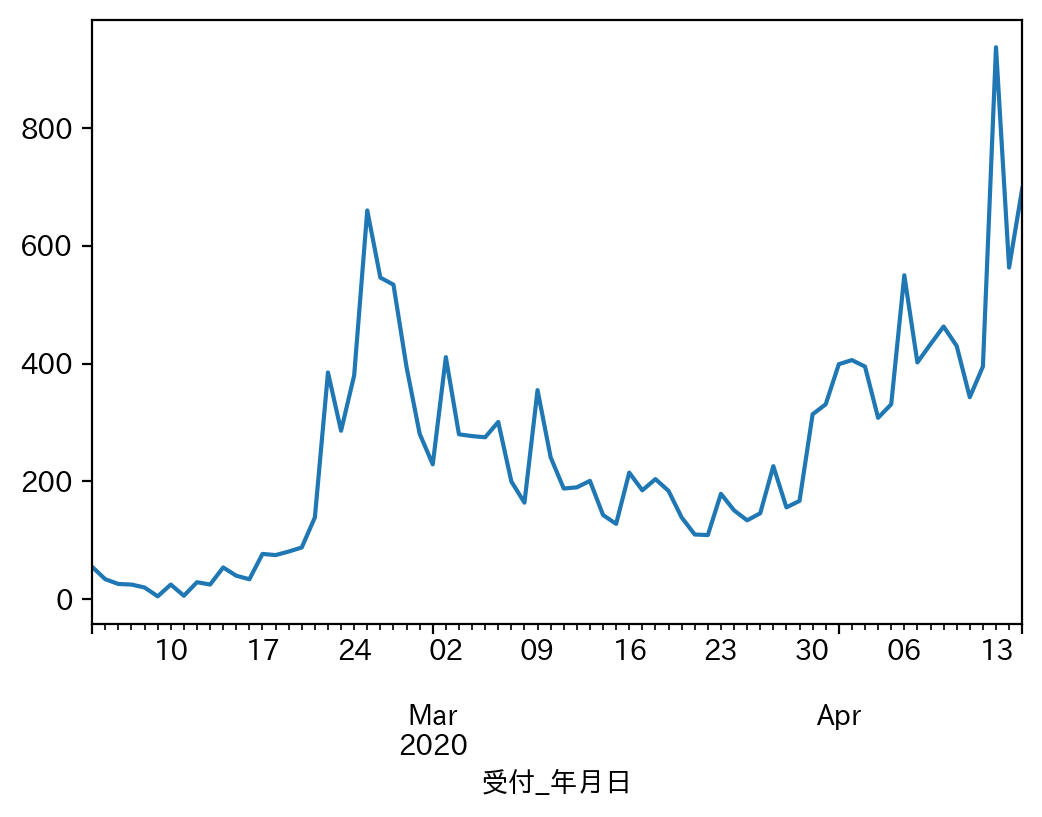

In [41]:
sr_contacts = pd.to_numeric(df_soudan["相談件数"], errors='coerce').dropna().astype(int)
sr_contacts.plot()

## 検査件数

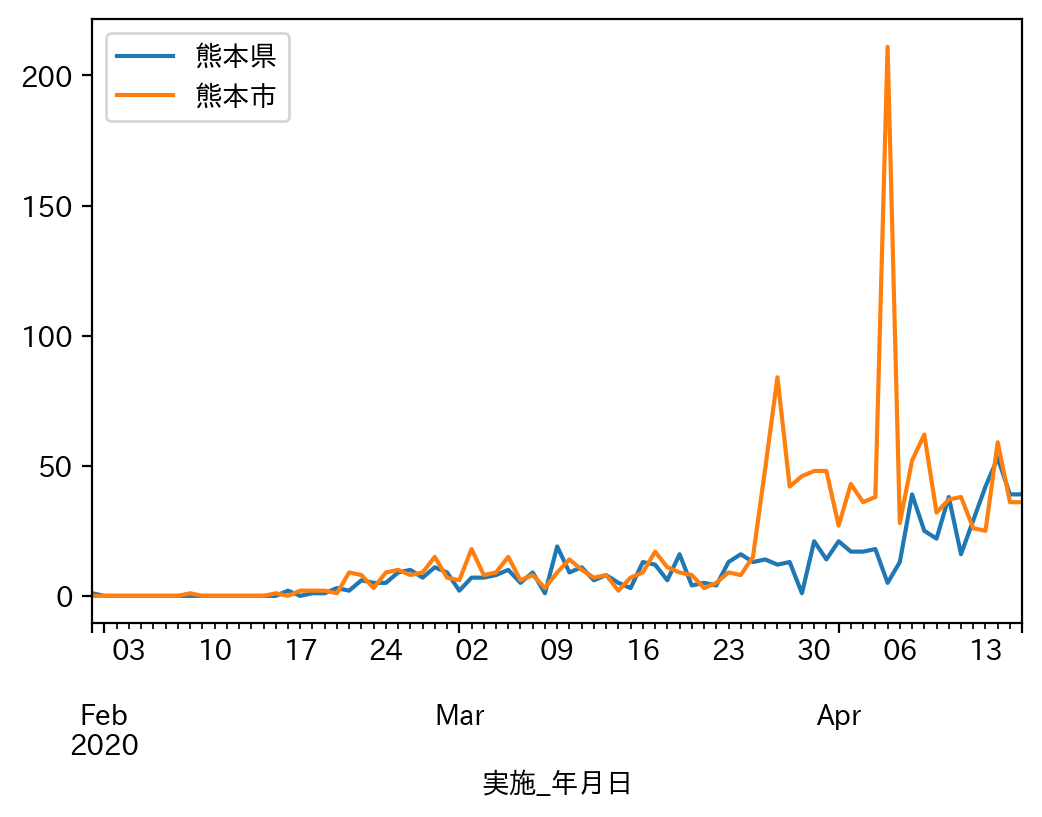

In [42]:
ax = df_kensa.plot()
ax.legend(title=None)

## 陽性患者

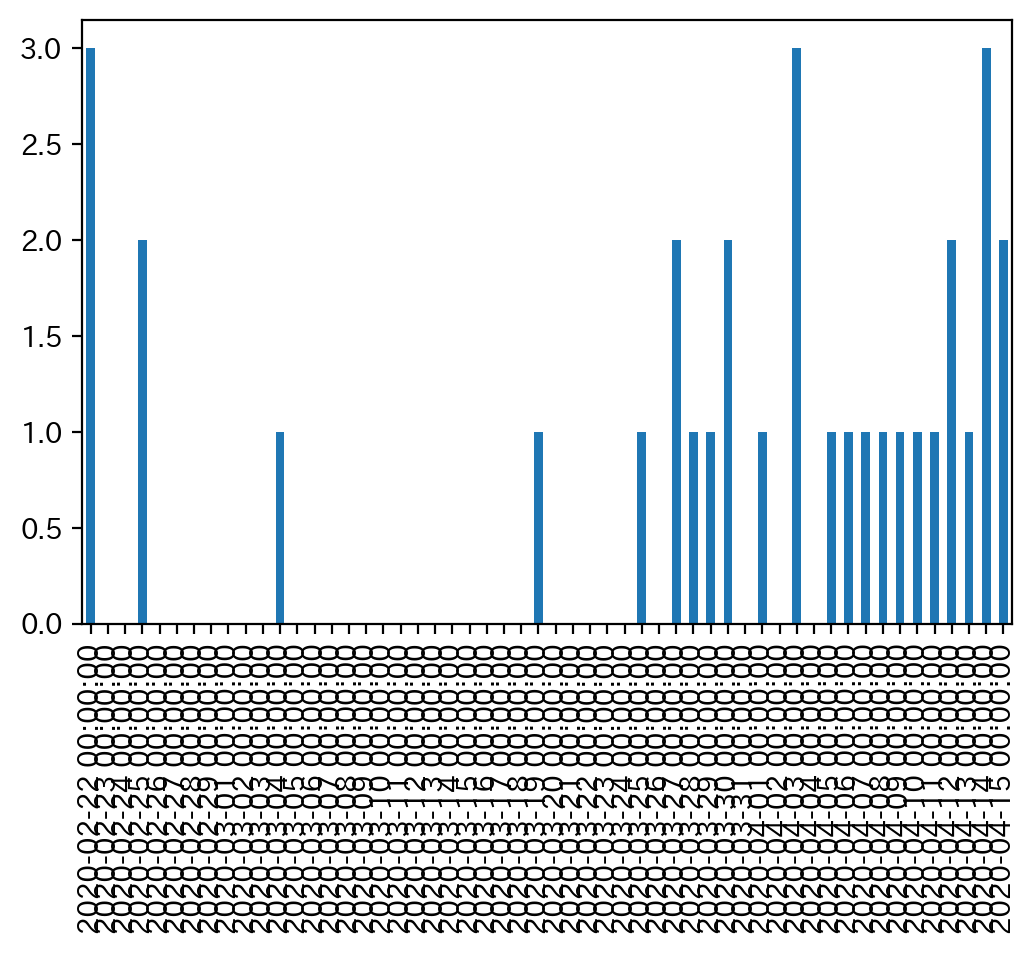

In [43]:
sr_pats = df_kanja["公表_年月日"].value_counts().sort_index().asfreq("D", fill_value=0)
sr_pats.plot.bar()

## 居住地別

In [0]:
df_area = pd.crosstab(df_kanja["確定_年月日"], df_kanja["居住地"])

## 居住地別（全期間）

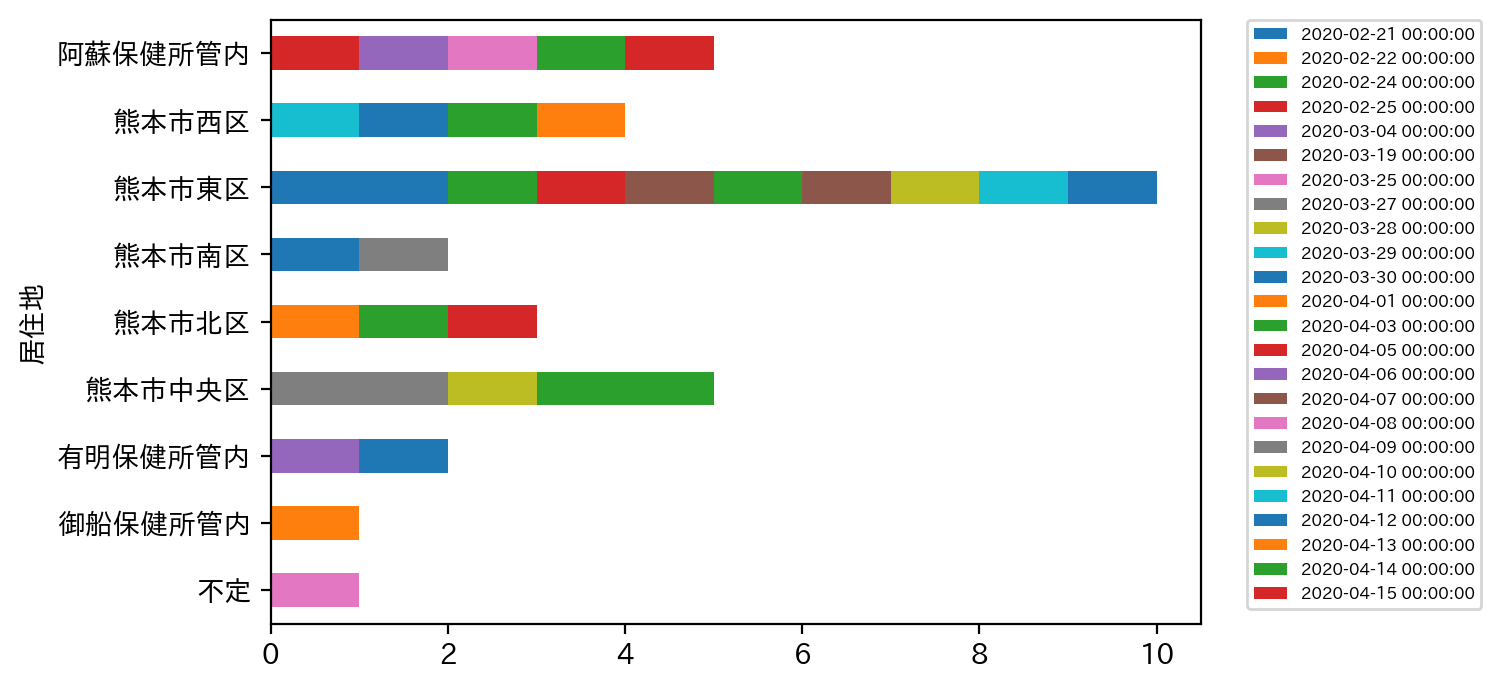

In [45]:
df_area.T.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=6)

## 居住地別（直近７日）

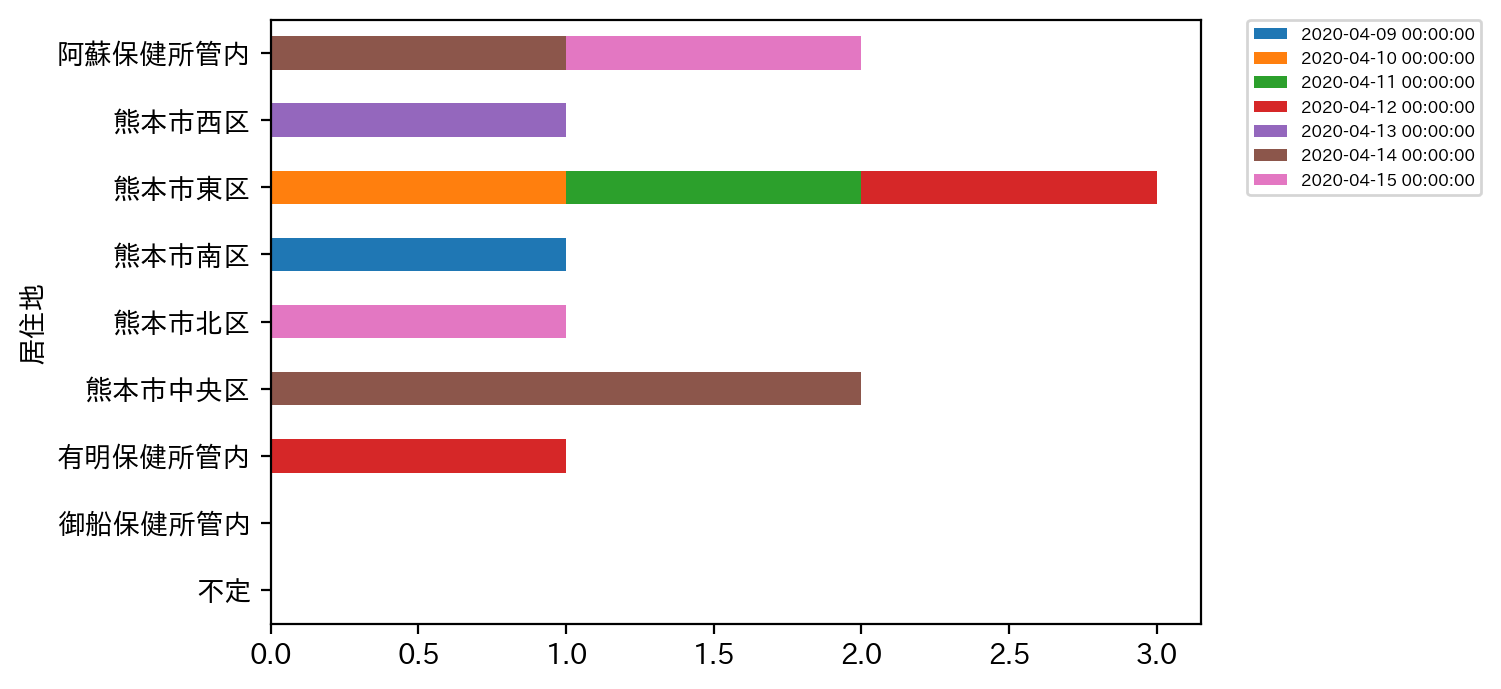

In [46]:
df_area.tail(7).T.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=6)

## 年代別

In [0]:
age_list = ["10歳未満","10代", "20代", "30代", "40代", "50代", "60代", "70代", "80代", "90歳以上", "非公表"]

In [0]:
df_age = df_kanja["年代"].value_counts().reindex(age_list, fill_value=0)

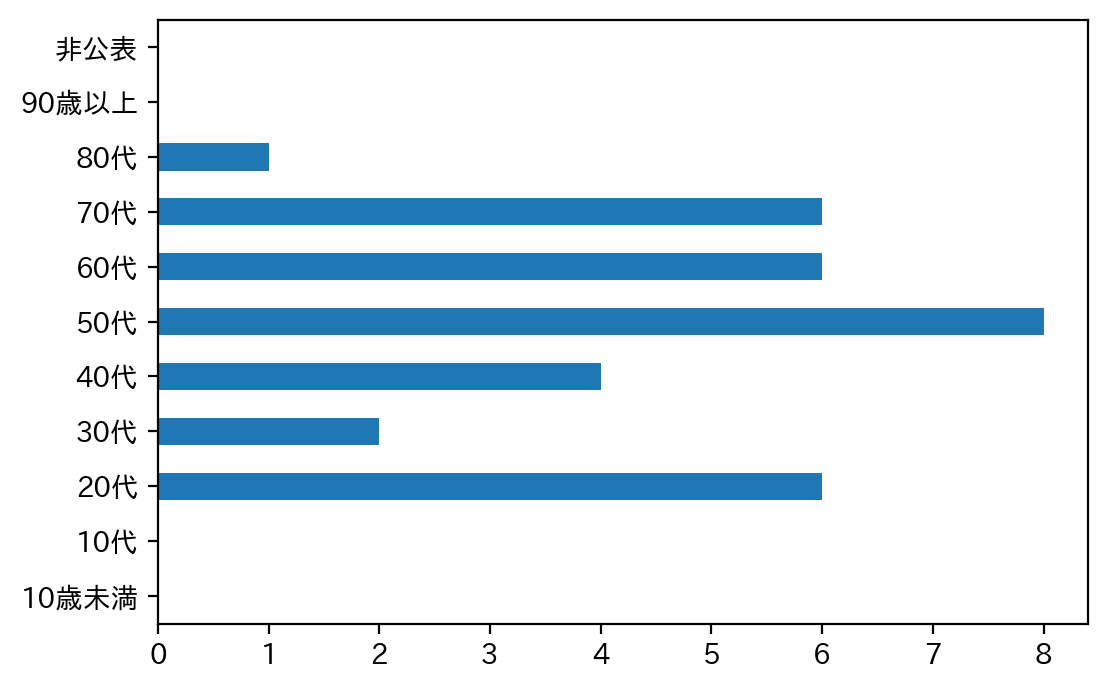

In [49]:
df_age.plot.barh()

## 性別

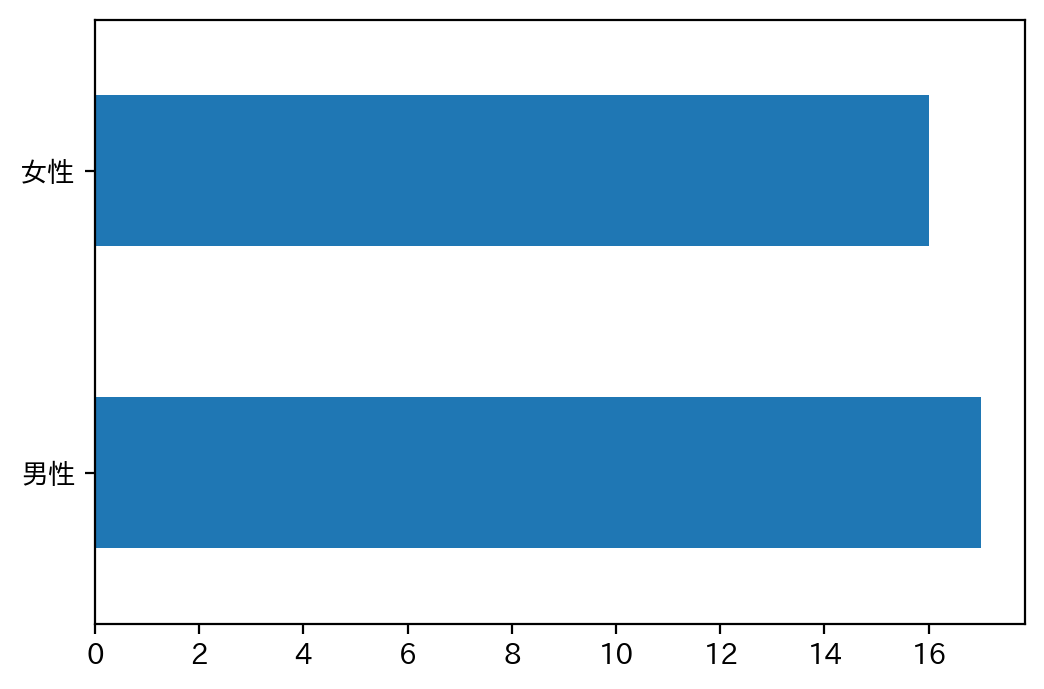

In [50]:
df_gender = df_kanja["性別"].value_counts()
df_gender.plot.barh()

## 職業別

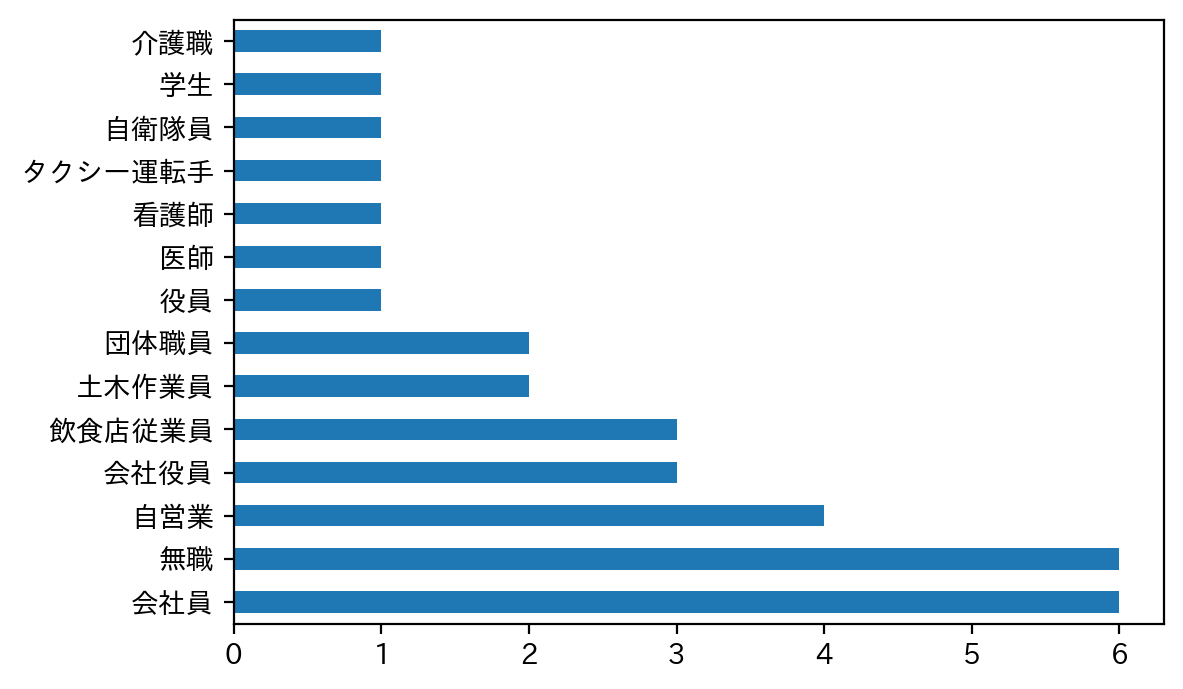

In [51]:
df_job = df_kanja["職業"].value_counts()
df_job.plot.barh()